In [2]:
%autoreload 2
import sys
sys.path.append('src')
import sqra
import numpy as np
import ajc
import ajcs
from scipy.linalg import expm


In [3]:
class doublewell:
    def __init__(self, nx = 5, ny = 1, xlims=(-1.5,1.5), ylims=(-1.5,1.5), dt=1, nt=6, auto=True):
        xs = np.linspace(*xlims, nx)
        ys = np.linspace(*ylims, ny)
        self.xs, self.ys = np.meshgrid(xs, ys, sparse=True)

        self.u = (self.xs**2-1)**2 + self.ys**2
        self.nt = nt
        self.nx = nx * ny
        self.dt = np.repeat(dt, nt)

        if auto:
            self.get_sqra()
            self.get_ajc()

    def get_sqra(self, **kwargs):
        self.sqra = sqra.Sqra(self.u, **kwargs)
        self.Qs = [self.sqra.Q.toarray()]*len(self.dt)

    
    def get_ajc(self):
        self.ajc = ajc.AJCGalerkin(np.dstack(self.Qs), np.array(self.dt))
        self.ajcs = ajcs.AJCS(self.Qs, self.dt)
        self.km = ajcs.flatten_spacetime(self.ajcs.k).toarray()

        def jumpfix(p):
            return np.reshape(p.flatten() @ self.km, p.shape)

        self.ajcs.jump = jumpfix

    def jumpactivity(self, p0):
        return self.ajcs.geiger(p0)

    def sync(self, p0):
        pp = self.jumpactivity(p0)
        return self.ajc.synchronize(pp.T)

    def koopman_sync(self):
        k = np.zeros((self.nx, self.nx))
        for i in range(self.nx):
            x0 = np.zeros((self.nt, self.nx))
            x0[0,i] = 1
            k[i, :] = self.sync(x0)[:,-1]
        return k

    def koopman_q(self):
        k = np.identity(self.nx)
        for (i,t) in enumerate(self.dt):
            k = k @ expm(t * self.Qs[i])
        return k

    def koopman_error(self):
        ks = self.koopman_sync()
        kq = self.koopman_q()
        return np.linalg.norm(ks-kq, 2)

d = doublewell()

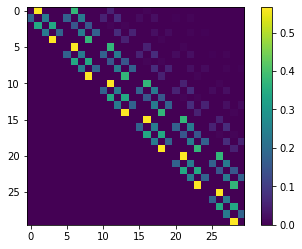

In [4]:
import matplotlib.pyplot as plt
plt.imshow(d.km)
plt.colorbar()

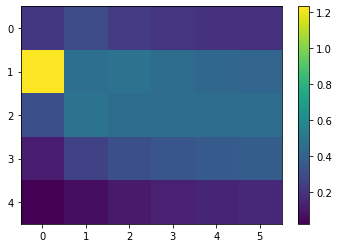

In [5]:
p0 = np.zeros((d.nt,d.nx))
p0[0,1] = 1

plt.imshow(d.jumpactivity(p0).T)
plt.colorbar()

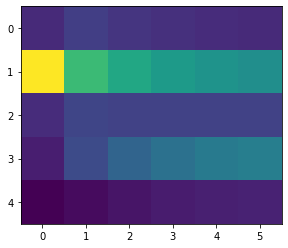

In [6]:
plt.imshow(d.sync(p0))

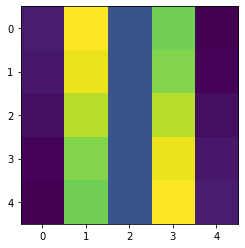

In [7]:
plt.imshow(d.koopman_sync())

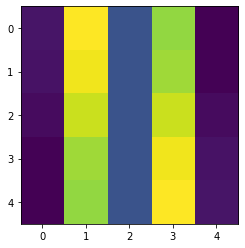

In [8]:
plt.imshow(d.koopman_q())

In [9]:
d.koopman_error()

0.02257414871864445

In [10]:
nts = np.arange(1,30)
errors = [doublewell(nt=nt, dt=1/nt, nx=100).koopman_error() for nt in nts]

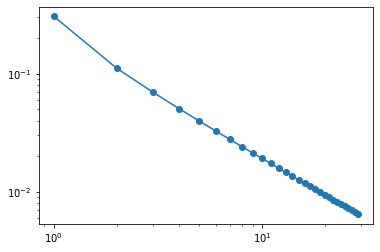

In [12]:
plt.yscale("log")
plt.xscale("log")
plt.plot(nts, errors)
plt.scatter(nts, errors)